# Noise detection

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from nltk import word_tokenize
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from stop_words import get_stop_words
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

from utils import add_epoch_division, linkage_matrix, plot_dendrogram, remove_noise_poet, text_cleaning

In [18]:
DIM_RED = False
LOWERCASE = True
MAX_FEATURES = 10000
PATH = "../corpora/amann_poems.csv"
REDUCE_CORPUS = False
STOP_WORDS = get_stop_words("de")

In [19]:
corpus = text_cleaning(pd.read_csv(PATH))

In [20]:
# reduce corpus
if REDUCE_CORPUS:
    epoch1 = "Frühaufklärung"
    epoch2 = "Realismus"
    corpus = corpus[(corpus.epoch == epoch1) | (corpus.epoch == epoch2)]

In [21]:
vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(corpus["poem"])

In [22]:
text = corpus["poem"]
shortened_classes = [c[:2] for c in corpus["epoch"].values]
ids = [p for p in corpus["id"].values]

## 1. Agglomerative Clustering

In [23]:
if DIM_RED:
    pca = PCA(n_components=3)
    X_red = pca.fit_transform(vector.toarray())
else:
    X_red = vector.toarray()

In [24]:
%%time
agcl = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model = agcl.fit(X_red)

CPU times: user 804 ms, sys: 7.43 ms, total: 811 ms
Wall time: 823 ms


In [25]:
def get_font_size(p):
    font_size = 12-p
    if font_size < 4:
        font_size = 4
    return font_size    

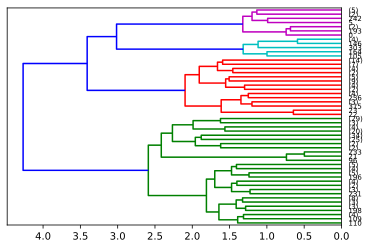

In [26]:
p = 5
cluster_labels = ids

l = dendrogram(linkage_matrix(model), 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=False,
               show_leaf_counts=True,
               show_contracted=False,
               get_leaves=True)
plt.show()

In [31]:
for i in range(1,20):

    p = i
    cluster_labels = ids

    l = dendrogram(linkage_matrix(model), 
                   p=p, 
                   truncate_mode='level', 
                   labels=cluster_labels, 
                   orientation="left",
                   leaf_font_size=get_font_size(p),
                   no_plot=True,
                   show_leaf_counts=False,
                   show_contracted=False,
                   get_leaves=True)
    
    print(f"{p} \t {len(l['ivl'])}")

1 	 4
2 	 8
3 	 16
4 	 31
5 	 52
6 	 84
7 	 124
8 	 155
9 	 183
10 	 210
11 	 221
12 	 232
13 	 242
14 	 246
15 	 247
16 	 247
17 	 247
18 	 247
19 	 247


In [32]:
p = 12
cluster_labels = ids

l = dendrogram(linkage_matrix(model), 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=True,
               show_leaf_counts=False,
               show_contracted=False,
               get_leaves=True)

print(f"{p} \t {len(l['ivl'])}")

12 	 232


### Remove noise with agglomerative clustering

In [33]:
not_noise = [leaf for leaf in l["ivl"] if leaf != ""]
noise = [leaf for leaf in ids if leaf not in not_noise]

noise_df = corpus[corpus["id"].isin(noise)]
noiseless_df = corpus[corpus["id"].isin(not_noise)]

In [132]:
#noiseless_df.to_csv("../corpora/amann_poems_noiseless.csv", index=False)

## 2. Topic Modelling

In [15]:
corpus.head(1)

,id,poet,poem,year,epoch,poemlength
0,0,"Abschatz, Hans Aßmann von",Was bleibt von Reichen unbekannt? Hält gleich ...,1678,Barock,75313


#### corpus to text

In [40]:
"""
for idx, row in corpus.iterrows():
    name = row.poet + "_" + row.epoch
    with open(f"../corpora/malletfiles/corpustext/{name}.txt", "w") as f:
        f.write(row.poem)
"""

'\nfor idx, row in corpus.iterrows():\n    name = row.poet + "_" + row.epoch\n    with open(f"../corpora/malletfiles/corpustext/{name}.txt", "w") as f:\n        f.write(row.poem)\n'

#### epochs to txt

In [37]:
"""
for epoch in list(corpus.epoch.unique()):
    df = corpus[corpus.epoch == epoch]
    Path(f"../corpora/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)
    for idx, row in df.iterrows():
        name = row.poet + "_" + row.epoch
        with open(f"../corpora/malletfiles/epochtexts/{epoch}/{name}.txt", "w") as f:
            f.write(row.poem)
"""

'\nfor epoch in list(corpus.epoch.unique()):\n    df = corpus[corpus.epoch == epoch]\n    Path(f"../corpora/epochtexts/{epoch}").mkdir(parents=True, exist_ok=True)\n    for idx, row in df.iterrows():\n        name = row.poet + "_" + row.epoch\n        with open(f"../corpora/epochtexts/{epoch}/{name}.txt", "w") as f:\n            f.write(row.poem)\n'

#### filter poets by topic

In [48]:
topic = "dat nich ick hei denn wat sin noch man sick tau seggt dor all herr mal sei min hett oll" 
topic = [w for w in topic.split(" ")]

In [50]:
topic_poets = {}
for idx, row in corpus.iterrows():
    text = word_tokenize(row.poem)
    topic_appearance = [w for w in topic if w in text]
    name = row.poet + "_" + row.epoch
    topic_poets[name] = len(topic_appearance)

In [51]:
len(topic)

NameError: name 'topic9' is not defined

In [33]:
min_count = 15
sorted_topic9_poets = {k: v for k, v in sorted(topic9_poets.items(), 
                                               key=lambda item: item[1], 
                                               reverse=True) if v >= min_count}

In [34]:
sorted_topic9_poets

{'Reuter, Fritz_Biedermeier': 20, 'Brinckman, John_Biedermeier': 19}

In [35]:
noise_poets = ["Reuter, Fritz", "Brinckman, John"]
corpus[corpus.poet.isin(noise_poets)]

,id,poet,poem,year,epoch,poemlength
21,21,"Brinckman, John","Dat wohrt so lang nu, as dat wohrt, ick, Vader...",1842,Biedermeier,31033
235,235,"Reuter, Fritz","Is in dat Dörp 'ne Kindelbier, Denn hungert un...",1842,Biedermeier,99870
